# Extracted Radar Columns and In-Situ Sensors (RadCLss) Dataset

## 14 March 2022 Case

In order to evaluate the SAIL field campaign snowfall retrievals, 
a dataset containing the radar column above each of our sites of interest, 
matched with in-situ ground observations is desired. 

## Current List of Supported In-Situ Ground Observations
- Pluvio Weighing Bucket Precipitation Gauge [WBPLUVIO2] (DOI: 10.5439/1338194)
- Surface Meteorological Instrumentation [MET] (DOI: 10.5439/1786358)
- Laser Disdrometer [LD] (DOI: 10.5439/1779709)
- Balloon-borne sounding system [SONDEWNPN] (DOI: 10.5439/1595321)
- Radar Wind Profiler [915RWPPRECIPMOMENTHIGH] 


## Imports

In [42]:
import glob
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pyart
import xarray as xr
import pandas as pd
import act
from matplotlib.dates import DateFormatter
from matplotlib import colors

## Define Processing Variables

In [2]:
# Define the desired processing date for the CSU XPRECIPRADAR in YYYY-MM-DD format.
DATE = "2022-03-14"
# Define the directory where the CSU-X Band CMAC2.0 files are located.
RADAR_DIR = "/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/"
# Define an output directory for downloaded ground instrumentation
INSITU_DIR = '/Users/jrobrien/ARM/inProgress/'

In [3]:
# Define ARM Username and ARM Token with ARM Live service for downloading ground instrumentation via ACT.DISCOVERY
# With your ARM username, you can find your ARM Live token here: https://adc.arm.gov/armlive/
ARM_USERNAME = os.getenv("ARM_USERNAME")
ARM_TOKEN = os.getenv("ARM_TOKEN")

## Define Functions 

In [4]:
def subset_points(file, lats, lons, sites):
    """Subset a radar file for a set of latitudes and longitudes"""
    
    # Read in the file
    radar = pyart.io.read(file)
    
    column_list = []
    for lat, lon in zip(lats, lons):
        # Make sure we are interpolating from the radar's location above sea level
        # NOTE: interpolating throughout Troposphere to match sonde to in the future
        da = pyart.util.columnsect.get_field_location(radar, lat, lon).interp(height=np.arange(np.round(radar.altitude['data'][0]), 10100, 100))
        # Add the latitude and longitude of the extracted column
        da["latitude"], da["longitude"] = lat, lon
        # Time is based off the start of the radar volume
        dt = pd.to_datetime(radar.time["data"], unit='s')[-1]
        da["time"] = [dt]
        column_list.append(da)
    # Concatenate the extracted radar columns for this scan across all sites    
    ds = xr.concat(column_list, dim='site')
    ds["site"] = sites
    # Add attributes for Time, Latitude, Longitude, and Sites
    ds.time.attrs.update(long_name=('Time in Seconds that Cooresponds to the Start'
                                    + " of each Individual Radar Volume Scan before"
                                    + " Concatenation"),
                         description=('Time in Seconds that Cooresponds to the Minimum'
                                      + ' Height Gate'))
    ds.site.attrs.update(long_name="SAIL/SPLASH In-Situ Ground Observation Site Identifers")
    ds.latitude.attrs.update(long_name='Latitude of SAIL Ground Observation Site',
                             units='Degrees North')
    ds.longitude.attrs.update(long_name='Longitude of SAIL Ground Observation Site',
                             units='Degrees East')
    return ds

In [5]:
def match_datasets_act(column, ground, site, discard, resample='sum', DataSet=False):
    """
    Time synchronization of a Ground Instrumentation Dataset to 
    a Radar Column for Specific Locations using the ARM ACT package
    
    Parameters
    ----------
    column : Xarray DataSet
        Xarray DataSet containing the extracted radar column above multiple locations.
        Dimensions should include Time, Height, Site
             
    ground : str; Xarray DataSet
        String containing the path of the ground instrumentation file that is desired
        to be included within the extracted radar column dataset. 
        If DataSet is set to True, ground is Xarray Dataset and will skip I/O. 
             
    site : str
        Location of the ground instrument. Should be included within the filename. 
        
    discard : list
        List containing the desired input ground instrumentation variables to be 
        removed from the xarray DataSet. 
    
    resample : str
        Mathematical operational for resampling ground instrumentation to the radar time.
        Default is to sum the data across the resampling period. Checks for mean. 
    
    DataSet : boolean
        Boolean flag to determine if ground input is an Xarray Dataset.
        Set to True if ground input is Xarray DataSet. 
             
    Returns
    -------
    ds : Xarray DataSet
        Xarray Dataset containing the time-synced in-situ ground observations with
        the inputed radar column 
    """
    # Check to see if input is xarray DataSet or a file path
    if DataSet == True:
        grd_ds = ground
    else:
        # Read in the file using ACT
        grd_ds = act.io.armfiles.read_netcdf(ground, cleanup_qc=True, drop_variables=discard)
        # Default are Lazy Arrays; convert for matching with column
        grd_ds = grd_ds.compute()
        
    # Remove Base_Time before Resampling Data since you can't force 1 datapoint to 5 min sum
    if 'base_time' in grd_ds.data_vars:
        del grd_ds['base_time']
        
    # Check to see if height is a dimension within the ground instrumentation. 
    # If so, first interpolate heights to match radar, before interpolating time.
    if 'height' in grd_ds.dims:
        grd_ds = grd_ds.interp(height=np.arange(column['height'].data[0], 10100, 100), method='linear')
        
    # Check to see if ground instrumentation is the RWP, as it has conflicting variable names
    # with the CMAC2.0 extracted radar columns
    if 'signal_to_noise_ratio' in grd_ds.data_vars:
        grd_ds = grd_ds.rename_vars(signal_to_noise_ratio='rwp_signal_to_noise_ratio')

    # Resample the ground data to 5 min and interpolate to the CSU X-Band time. 
    # Keep data variable attributes to help distingish between instruments/locations
    if resample.split('=')[-1] == 'mean':
        matched = grd_ds.resample(time='5Min', 
                                  closed='right').mean(keep_attrs=True).interp(time=column.time, 
                                                                               method='linear') 
    else:
        matched = grd_ds.resample(time='5Min', 
                                  closed='right').sum(keep_attrs=True).interp(time=column.time, 
                                                                              method='linear')
    
    # Add SAIL site location as a dimension for the Pluvio data
    matched = matched.assign_coords(coords=dict(site=site))
    matched = matched.expand_dims('site')
   
    # Remove Lat/Lon Data variables as it is included within the Matched Dataset with Site Identfiers
    if 'lat' in matched.data_vars:
        del matched['lat']
    if 'lon' in matched.data_vars:
        del matched['lon']
        
    # Update the individual Variables to Hold Global Attributes
    # global attributes will be lost on merging into the matched dataset.
    # Need to keep as many references and descriptors as possible
    for var in matched.data_vars:
        matched[var].attrs.update(source=matched.datastream)
        
    # Merge the two DataSets
    column = xr.merge([column, matched])
   
    return column

## Define the Location of the SAIL Sites. 

In [6]:
# Define the splash locations [lon,lat]
kettle_ponds = [-106.9731488, 38.9415427]
brush_creek = [-106.920259, 38.8596282]
avery_point = [-106.9965928, 38.9705885]
pumphouse_site = [-106.9502476, 38.9226741]
roaring_judy = [-106.8530215, 38.7170576]
M1 = [-106.987, 38.9267]
snodgrass = [-106.978929, 38.926572]

sites = ["M1", "kettle_ponds", "brush_creek", "avery_point", 
         "pumphouse_site", "roaring_judy", "snodgrass"]

# Zip these together!
lons, lats = list(zip(M1,
                      kettle_ponds,
                      brush_creek,
                      avery_point,
                      pumphouse_site,
                      roaring_judy,
                      snodgrass))

## List the Available CSU X-Band Corrected Precipitation Radar Moments in Antenna Coordinates Version 2 (CMAC2.0) Files

#### In contrast to the Merged CSU X-Band files previously used, the CSU X-Band CMAC2.0 files have been corrected for beam blockage and clutter, as well as, undergone additional processing. 

#### Z-S Relationships previously explored are applied during the CMAC2.0 processing of the CSU X-Band data. Therefore, all we need to do now is extract the radar columns and combine with ground instruments. 

In [7]:
# With the user defined RADAR_DIR, grab all the XPRECIPRADAR CMAC files for the defined DATE
file_list = sorted(glob.glob(RADAR_DIR + '*' + DATE.replace('-', '') + '*.nc'))
file_list[:10]

['/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-000239.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-001319.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-003439.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-004519.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-005039.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-011159.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-013839.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-015439.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-021039.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-021559.nc']

In [8]:
%%time
ds_list = []
for file in file_list[:]:
    print(file)
    ds_list.append(subset_points(file, lats, lons, sites))

/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-000239.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-001319.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-003439.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-004519.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-005039.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-011159.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-013839.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-015439.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-021039.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-021559.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.2022031

/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-185325.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-185845.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-190405.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-190925.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-192005.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-192525.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-193045.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-195205.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-195725.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-200805.nc
/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.2022031

## Combine all Extracted Radar Columns to Form Daily Timeseries

In [9]:
# Concatenate all extracted columns across time dimension to form daily timeseries
ds = xr.concat(ds_list, dim='time')

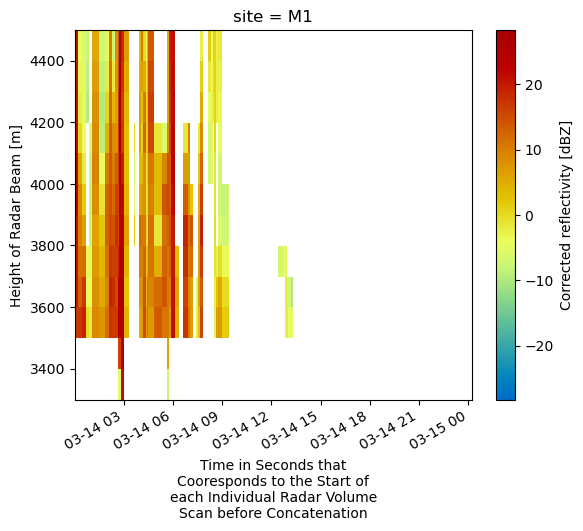

In [10]:
ds.sel(site='M1').sel(height=slice(3300, 4500)).corrected_reflectivity.plot(x='time',
                                                                            cmap='pyart_HomeyerRainbow')

In [11]:
# Remove Global Attributes from the Column Extraction
# Attributes make sense for single location, but not collection of sites. 
ds.attrs = {}

In [12]:
# Remove the Base_Time variable from extracted column
del ds['base_time']

In [13]:
ds

<xarray.Dataset>
Dimensions:                                   (time: 118, site: 7, height: 70)
Coordinates:
  * height                                    (height) float64 3.149e+03 ... ...
  * time                                      (time) datetime64[ns] 2022-03-1...
  * site                                      (site) <U14 'M1' ... 'snodgrass'
Data variables: (12/34)
    DBZ                                       (time, site, height) float64 na...
    VEL                                       (time, site, height) float64 na...
    WIDTH                                     (time, site, height) float64 na...
    ZDR                                       (time, site, height) float64 na...
    PHIDP                                     (time, site, height) float64 na...
    RHOHV                                     (time, site, height) float64 na...
    ...                                        ...
    snow_rate_ws2012                          (time, site, height) float64 na...
    snow_rate_ws88diw                         (time, site, height) float64 na...
    snow_rate_m2009_1                         (time, site, height) float64 na...
    snow_rate_m2009_2                         (time, site, height) float64 na...
    latitude                                  (time, site) float64 38.93 ... ...
    longitude                                 (time, site) float64 -107.0 ......

## Define Dictionary of Variables to Remove from Each Datastream

In [14]:
discard_var = {'LD' : ['base_time', 'time_offset', 'equivalent_radar_reflectivity_ott',
                      'laserband_amplitude', 'qc_equivalent_radar_reflectivity_ott',
                      'qc_laserband_amplitude', 'sensor_temperature',
                      'heating_current', 'qc_heating_current', 'sensor_voltage',
                      'qc_sensor_voltage', 'moment1', 'moment2', 'moment3', 'moment4',
                      'moment5', 'moment6', 'lat', 'lon', 'alt'
                      ],
               'Pluvio' : ['base_time', 'time_offset', 'load_cell_temp', 'heater_status',
                          'elec_unit_temp', 'supply_volts', 'orifice_temp', 'volt_min',
                          'ptemp', 'lat', 'lon', 'alt'
                          ],
               'Met' : ['base_time', 'time_offset', 'time_bounds', 'logger_volt', 'qc_logger_volt',
                       'logger_temp', 'qc_logger_temp', 'lat', 'lon', 'alt'
                       ],
               'Sonde' : ['base_time', 'time_offset', 'lat', 'lon'],
               'RWP' : ['base_time', 'time_offset', 'time_bounds', 'height_bounds',
                        'lat', 'lon', 'alt'
                       ]
              }

## 1) Add in the Pluvio Weighing Bucket Data

In [15]:
# We can use the ACT module for downloading data from the ARM web service
if ARM_USERNAME is None or ARM_TOKEN is None or len(ARM_USERNAME) == 0 or len(ARM_TOKEN) == 0:
    print("ACT Username and Token Not Found ")
else:
    results = act.discovery.download_data(ARM_USERNAME, 
                                          ARM_TOKEN, 
                                          'gucwbpluvio2M1.a1', 
                                          DATE, 
                                          DATE, 
                                          output=INSITU_DIR)

[DOWNLOADING] gucwbpluvio2M1.a1.20220314.000000.nc


In [16]:
# Define the file path
npluvio = sorted(glob.glob(INSITU_DIR + '*gucwbpluvio2M1.a1.' +DATE.replace('-','') + '*'))
# Define the site location based on the filename
pluv_site = npluvio[0].split('gucwbpluvio2')[-1].split('.')[0]

In [17]:
# Call Match Datasets ACT 
ds = match_datasets_act(ds, npluvio[0], pluv_site, discard=discard_var['Pluvio'])

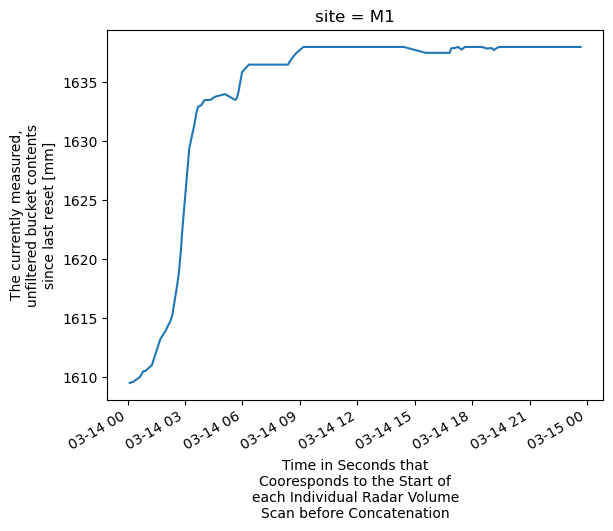

In [18]:
# Plot the Weighing Bucket accumulation at the M1 site
# Test to make sure Pluvio is correctly merged in with extracted column. 
ds.sel(site='M1').bucket_rt.plot(x='time')

## 2) Add the Surface Meteorological Station (MET) to the Matched Dataset

In [19]:
# We can use the ACT module for downloading data from the ARM web service
if ARM_USERNAME is None or ARM_TOKEN is None or len(ARM_USERNAME) == 0 or len(ARM_TOKEN) == 0:
    print("ACT Username and Token Not Found ")
else:
    results = act.discovery.download_data(ARM_USERNAME, 
                                          ARM_TOKEN, 
                                          'gucmetM1.b1',
                                          DATE, 
                                          DATE, 
                                          output=INSITU_DIR)

[DOWNLOADING] gucmetM1.b1.20220314.000000.cdf


In [20]:
# Define the file path
nmet = sorted(glob.glob(INSITU_DIR + '*gucmetM1.b1.' + DATE.replace('-', '') + '*'))
# Define the site location based on the filename
met_site = nmet[0].split('gucmet')[-1].split('.')[0]

In [21]:
# Call Match Datasets ACT
ds = match_datasets_act(ds, nmet[0], met_site, discard=discard_var['Met'])

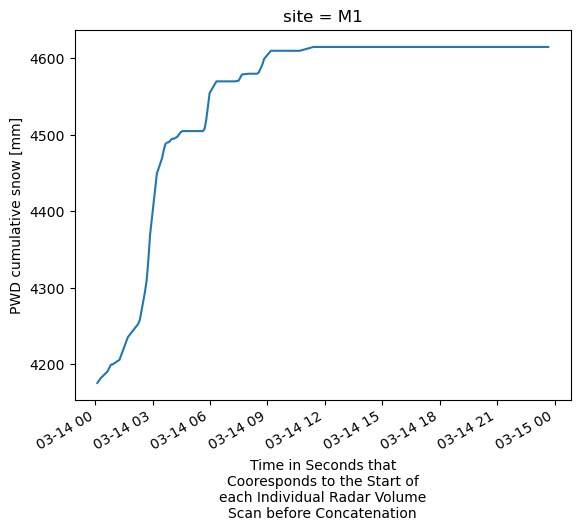

In [22]:
# Plot the MET accumulation at the M1 site
# Test to make sure MET is correctly merged in with extracted column. 
ds.sel(site='M1').pwd_cumul_snow.plot(x='time')

## 3) Add the Laser Disdrometer to the Matched Dataset  - M1 Sites

In [23]:
# We can use the ACT module for downloading data from the ARM web service
if ARM_USERNAME is None or ARM_TOKEN is None or len(ARM_USERNAME) == 0 or len(ARM_TOKEN) == 0:
    print("ACT Username and Token Not Found ")
else:
    results = act.discovery.download_data(ARM_USERNAME, 
                                          ARM_TOKEN, 
                                          'gucldM1.b1',
                                          DATE, 
                                          DATE, 
                                          output=INSITU_DIR)

[DOWNLOADING] gucldM1.b1.20220314.000000.cdf


In [24]:
# Define the file path
nld = sorted(glob.glob(INSITU_DIR + '*gucldM1.b1.' + DATE.replace('-', '') + '*'))
# Define the site location based on the filename
ld_site = nld[0].split('gucld')[-1].split('.')[0]

In [25]:
# Call Match Datasets ACT
ds = match_datasets_act(ds, nld[0], ld_site, discard=discard_var['LD'])

## 4) Add Second Laser Disdrometer - S2 Site

In [26]:
# We can use the ACT module for downloading data from the ARM web service
if ARM_USERNAME is None or ARM_TOKEN is None or len(ARM_USERNAME) == 0 or len(ARM_TOKEN) == 0:
    print("ACT Username and Token Not Found ")
else:
    results = act.discovery.download_data(ARM_USERNAME, 
                                          ARM_TOKEN, 
                                          'gucldS2.b1',
                                          DATE, 
                                          DATE, 
                                          output=INSITU_DIR)

[DOWNLOADING] gucldS2.b1.20220314.000000.cdf


In [27]:
# Define the file path
ld_2 = sorted(glob.glob(INSITU_DIR + '*gucldS2.b1.' + DATE.replace('-', '') + '*'))
# Define the site location based on the filename
ld2_site = ld_2[0].split('gucld')[-1].split('.')[0]

In [28]:
# Call Match Datasets ACT
ds = match_datasets_act(ds, ld_2[0], ld2_site, discard=discard_var['LD'])

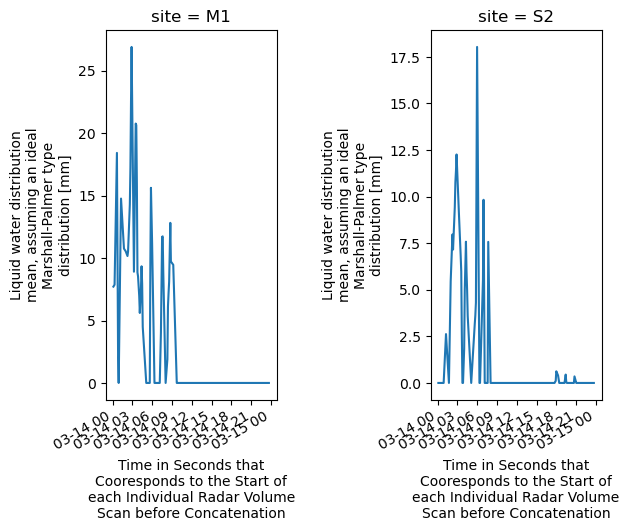

In [29]:
# Sanity Check - Plot LD from M1 and S2 sites to verify datastreams merged correctly
fig, axarr = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.9, hspace=1.2)

ds.liquid_water_distribution_mean.sel(site='M1').plot(ax=axarr[0])
ds.liquid_water_distribution_mean.sel(site='S2').plot(ax=axarr[1])

## 5) Add the Radar Wind Profiler (High Powered)

##### NOTE: RWP Data are missing for March 14, 2022; ACT Discovery will alert if data are unavailable

In [30]:
# We can use the ACT module for downloading data from the ARM web service
if ARM_USERNAME is None or ARM_TOKEN is None or len(ARM_USERNAME) == 0 or len(ARM_TOKEN) == 0:
    print("ACT Username and Token Not Found ")
else:
    results = act.discovery.download_data(ARM_USERNAME, 
                                          ARM_TOKEN, 
                                          'guc915rwpprecipmomenthighM1.a0',
                                          DATE, 
                                          DATE, 
                                          output=INSITU_DIR)

No files returned or url status error.
Check datastream name, start, and end date.


In [31]:
# Define the file path
nrwp = sorted(glob.glob(INSITU_DIR + '*guc915rwpprecipmomenthighM1.a0.' + DATE.replace('-', '') + '*'))
if len(nrwp) > 0:
    # Define the site location based on the filename
    rwp_site = nrwp[0].split('guc915rwpprecipmomenthigh')[-1].split('.')[0]

    # Call Match Datasets ACT
    ds = match_datasets_act(ds, nrwp[0], rwp_site, resample='mean', discard=discard_var['RWP'])

    # Check to make sure the RWP datastream merged in correctly
    ds.sel(site='M1').doppler_velocity.plot(x='time')

## 6) Add the Radiosonde Data

### Note: There could be multiple launches per day and not all are successful. 

In [32]:
# We can use the ACT module for downloading data from the ARM web service
if ARM_USERNAME is None or ARM_TOKEN is None or len(ARM_USERNAME) == 0 or len(ARM_TOKEN) == 0:
    print("ACT Username and Token Not Found ")
else:
    results = act.discovery.download_data(ARM_USERNAME, 
                                          ARM_TOKEN, 
                                          'gucsondewnpnM1',
                                          DATE, 
                                          DATE, 
                                          output=INSITU_DIR)

[DOWNLOADING] gucsondewnpnM1.b1.20220314.113200.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20220314.115700.cdf
[DOWNLOADING] gucsondewnpnM1.b1.20220314.233000.cdf


In [33]:
# Search for all sonde files
nsonde = sorted(glob.glob(INSITU_DIR + "*gucsondewnpnM1.b1." + DATE.replace('-', '') + '*'))

# Open each individual Sonde File and Merge together
sonde_list = []
for nfile in nsonde:
    sonde = act.io.armfiles.read_netcdf(nfile)
    # Check to make sure launch was successful (e.g. time > 1 obs)
    if sonde.time.shape[0] > 1:
        sonde_list.append(sonde)
# Concatenate together the sonde xarray DataSets
ds_sonde = xr.concat(sonde_list, dim='time').compute()
# Define the site location based on the filename
sonde_site = nsonde[0].split('gucsondewnpn')[-1].split('.')[0]

In [34]:
ds = match_datasets_act(ds, ds_sonde, sonde_site, DataSet=True, discard=discard_var['Sonde'])

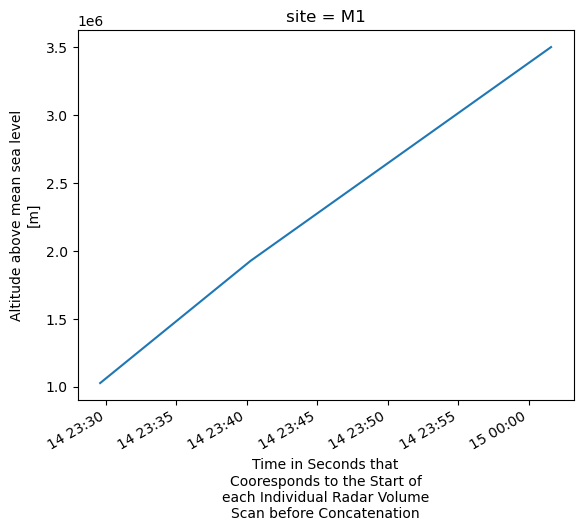

In [35]:
ds.sel(site='M1').alt.plot()

## 7) Define the Meta Data Standards for Matched Dataset

In [36]:
# Call the Data Object Definitions for this datastream. 
# Will create an xarray dataset which will contain the necessary meta data and variables. 
mdims = {"time": ds['time'].data.shape[0], "height": 70, "site": 8, "particle_size": 32, "raw_fall_velocity": 32}
out_ds = act.io.create_obj_from_arm_dod('xprecipradarradclss.c2', mdims, version='1.0')

In [37]:
# Transform the matched dataset for consistent dimensions
ds = ds.transpose('time', 'height', 'site', 'particle_size', 'raw_fall_velocity')

In [38]:
# Output Dataset has correct data attributes, supplied by the DOD. 
# Update the output dataset variable values with the matched dataset. 
for var in out_ds.variables:
    if var not in out_ds.dims:
        # check to see if variable is within the matched dataset
        # note: it may not be if file is missing.
        if var in ds.variables:
            out_ds[var].data = ds[var].data

In [39]:
# Update the coordinates with the matched dataset values
out_ds = out_ds.assign_coords(time = ds['time'].data, 
                              height = ds['height'].data, 
                              site = ds['site'].data, 
                              particle_size = ds['particle_size'].data,
                              raw_fall_velocity = ds['raw_fall_velocity'].data)

In [40]:
out_ds

<xarray.Dataset>
Dimensions:                                   (time: 118, height: 70, site: 8,
                                               particle_size: 32,
                                               raw_fall_velocity: 32)
Coordinates:
  * time                                      (time) datetime64[ns] 2022-03-1...
  * height                                    (height) float64 3.149e+03 ... ...
  * site                                      (site) <U14 'M1' ... 'snodgrass'
  * particle_size                             (particle_size) float32 0.062 ....
  * raw_fall_velocity                         (raw_fall_velocity) float32 0.0...
Data variables: (12/121)
    DBZ                                       (time, height, site) float64 na...
    VEL                                       (time, height, site) float64 na...
    WIDTH                                     (time, height, site) float64 na...
    ZDR                                       (time, height, site) float64 na...
    PHIDP                                     (time, height, site) float64 na...
    RHOHV                                     (time, height, site) float64 na...
    ...                                        ...
    v_wind                                    (time, site) float64 nan ... nan
    wstat                                     (time, site) float64 nan ... nan
    asc                                       (time, site) float64 nan ... nan
    lat                                       (site) float64 -9.999e+03 ... -...
    lon                                       (site) float64 -9.999e+03 ... -...
    alt                                       (time, site) float64 nan ... nan
Attributes: (12/24)
    command_line:          
    Conventions:           ARM-1.3 CF/Radial instrument_parameters
    process_version:       
    dod_version:           
    input_datastreams:     
    site_id:               
    ...                    ...
    developers:            Joseph O'Brien, ANL. Maxwell Grover, ANL. Robert J...
    translator:            https://www.arm.gov/capabilities/instruments/xprec...
    mentors:               https://www.arm.gov/connect-with-arm/organization/...
    source:                Colorado State University's X-Band Precipitation R...
    field_names:           DBZ, VEL, WIDTH, ZDR, PHIDP, RHOHV, NCP, DBZhv, cb...
    history:

## 8) Save the DataSet

In [41]:
# define a filename
out_ds.to_netcdf('xprecipradarradclss.c2.' + DATE.replace('-', '') + '.000000.nc')